# Bayesian Neural Networks 

This script explores using pytorch and pyro to build, train and test a bayesian neural network. The advantage and novelty of this model is that inference is done probablistically; thereby allowing us to quantify the certainty of model results. Kind of like a built in sensitivity  analysis. 

I like the way [this](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd) [3] tutorial phrases it:  

> Making Your Neural Network Say “I Don’t Know”

In this tutorial, we'll go over 
- key differences of `Bayesian Neural Networks (BNN)` vs `Neural Networks (NN)` 
- how BNNs do inference & training 
- simple tutorial on how to build a BNN using `pytorch` and `pyro` 
- difference in training and prediction time complexity 

# BNNs vs NNs 

## Classic Neural Network 


## Bayesian Neural Network 

![image.png](https://www.researchgate.net/profile/Florian_Haese/publication/329843608/figure/fig2/AS:713727343067138@1547177267367/llustration-of-a-Bayesian-Neural-Network-BNN-A-A-Bayesian-neuron-defines-a_W640.jpg)
Taken from [1]. 


# BNN advantage


## What happens when you give cutting edge neural network an image of noise? 

![image.png](https://miro.medium.com/max/802/0*HG51qQU8I34_fUgB.jpg)

--- 

The most obvious advantage of these BNNs are that they allow the model to propogate it's uncertainty about a prediction, from [this]( https://krasserm.github.io/2019/03/14/bayesian-neural-networks/) tutorial, there is a great plot that shows this.

![image.png](https://krasserm.github.io/img/2019-03-14/output_9_1.png)

From this we can see that the BNN knows where in it's feature space it has accurate predictions, and where it does not. I've been thinking about this as a built in sensitivity analysis. With a few extra lines of code, we can have the model say, "Hey, I don't know what the answer is, don't trust me", which is a key feature when making important decisions. 

Other advantages include being able to include priors on our weight distributions (could be tough to know how to do this well). Also priors on our X distributions, which could be as simple as calculating p(x) over each mini-batch of the training set and using this as the prior on test sets. 

# Training a BNN 

## Variation Inference 


## Sampling 


# Prediction 

In [1]:
import torch
import torch.nn.functional as nnf
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.optim import SGD
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
from torchvision.datasets.mnist import MNIST
from torch import nn
from pyro.infer import SVI, TraceMeanField_ELBO
import pyro
from pyro import poutine
import pyro.optim as pyroopt
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions.utils import lazy_property
import math
from torch.utils import data
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
import numpy as np

# Model Global Variables 

In [2]:
LEARNING_WEIGHT = 1e-3
EPOCHS = 150
DECAY_MILESTONES = range(100, EPOCHS, 10)
GAMMA=0.1
DROP_OUT_PROP = 0.1
LAYER_SIZE= 50

# Load our data in 

We'll use the classic `Iris` Dataset.

number of features: 4 
number of observations: 150
number of classes: 3 

We'll save each observation separately to disk as a tensor object (.pt), so that we can build an efficient DataLoader (for learning purposes, since our volume doesn't actually make this necessary) 

Also, since we're just exploring the difference between these two models, we'll only split to train/test 2:1 ratio. 

In [3]:
X,Y = load_iris(return_X_y=True)

# shuffle our data to avoid class bias 
sel = np.arange(len(Y))
np.random.shuffle(sel)
X = X[sel]
Y = Y[sel]

for i,x in enumerate(X):
    torch.save(torch.tensor(x).float(), './data/%d.pt' %i)

n_classes=len(set(Y))
print(f'Number of classes: {n_classes}')

partition = {'train':[str(x) for x in range(0,100)],
             'test':[str(x) for x in range(100,150)]}

labels = {str(i):torch.tensor(j).to(torch.int64) for i,j in zip(range(150), Y)}

Number of classes: 3


# Dataset Class: first part of our DataLoader 

We have to define a dataset class, which is where we can tell the dataloader where to look for each observation (key -> path) 

In [4]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data, load from disk'
        ID = self.list_IDs[index]
        X = torch.load('data/' + ID + '.pt')
        y = self.labels[ID]
        return X, y

# Housekeeping 

choose the device to train on, we'll do it locally on a single thread. 

In [5]:
# CUDA for PyTorch
device = torch.device('cpu')

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Initialize our DataLoaders 

We'll use our whole training dataset as the batch, since we have so little data anyway. No need to optimize here. 

In [6]:
# CUDA for PyTorch
device = torch.device('cpu')

# Parameters
train_params = {'batch_size': 100,
          'shuffle': True,
          'num_workers': 0}

# Generators
training_set = Dataset(partition['train'], labels)
train_loader = data.DataLoader(training_set, **train_params)

# Parameters
test_params = {'batch_size': 50,
          'shuffle': False,
          'num_workers': 0}

test_set = Dataset(partition['test'], labels)
test_loader = data.DataLoader(test_set, **test_params)

# Define our classic neural network 

![](https://media.wired.com/photos/592676bf7034dc5f91beb823/16:9/w_1600,c_limit/1957_Jaguar_XKSS_0043_BH-FINAL.jpg)

In [7]:
class Common_FCN(nn.Module):
    def __init__(self, n_classes=n_classes):
        super(Common_FCN, self).__init__()
        self.fc = nn.Sequential(#nn.BatchNorm1d(num_features=4),
                                #nn.Dropout(p=DROP_OUT_PROP),
                                nn.Linear(4, LAYER_SIZE),
                                #nn.BatchNorm1d(num_features=LAYER_SIZE),
                                #nn.Dropout(p=DROP_OUT_PROP),
                                nn.ReLU(),
                                #nn.Dropout(p=DROP_OUT_PROP),
                                nn.Linear(LAYER_SIZE, LAYER_SIZE),
                                nn.ReLU(),
                                nn.Linear(LAYER_SIZE, n_classes),
                                nn.Softmax(dim=-1))

    def forward(self, inp):
        return self.fc(inp)

# Define our Bayesian Neural Network 



# Initialize our model, gradient descent alg, learning rate decay

In [8]:
FC_NN = Common_FCN()

optim = torch.optim.AdamW(FC_NN.parameters(recurse=True), lr=LEARNING_WEIGHT, weight_decay=0.01, amsgrad=True)#SGD(FC_NN.parameters(recurse=True), lr=0.1, momentum=0.95)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=DECAY_MILESTONES, gamma=GAMMA)

# Initialize our model and perform the training loop 

In [9]:
if __name__ == '__main__': # need to wrap our training function in this 
    
    training_state = {'train_acc':[], 'test_acc':[]}

    for i in range(EPOCHS):
        total_loss = 0.0
        total = 0.0
        correct = 0.0
        for x, y in train_loader:
            FC_NN.zero_grad()
            pred = FC_NN.forward(x)
            loss = nnf.binary_cross_entropy(pred, nnf.one_hot(y, torch.tensor(n_classes)).float())
            total_loss += loss
            total += y.size(0)
            correct += (pred.argmax(-1) == y).sum().item()
            loss.backward()
            tracc = correct/total*100
            optim.step()
        scheduler.step()

        FC_NN.eval() # set eval mode - w/o dropout
        total = 0.0
        correct = 0.0
        for x, y in test_loader:
            pred = FC_NN.forward(x)
            total += y.size(0)
            correct += (pred.argmax(-1) == y).sum().item()
            teacc = correct/total*100
        FC_NN.train() # reset to training mode - w/ dropout
        training_state['train_acc'].append(tracc)
        training_state['test_acc'].append(teacc)
        print('epoch: %d | learning rate: %f | train loss: %.3f | train acc: %.5f' %((i+1), get_lr(optim), total_loss, tracc), end='\r')

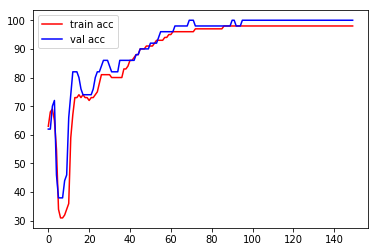

In [10]:
    plt.figure()
    plt.plot(training_state['train_acc'], 'r-', label='train acc')
    plt.plot(training_state['test_acc'], 'b-', label='val acc')
    plt.legend()
    plt.show()

# References 

1.How machine learning can assist the interpretation of ab initio molecular dynamics simulations and conceptual understanding of chemistry. ResearchGate https://www.researchgate.net/publication/329843608_How_machine_learning_can_assist_the_interpretation_of_ab_initio_molecular_dynamics_simulations_and_conceptual_understanding_of_chemistry/figures?lo=1.

2.Variational inference for Bayesian neural networks - Martin Krasser’s Blog. https://krasserm.github.io/2019/03/14/bayesian-neural-networks/.

3.Chopra, P. Making Your Neural Network Say “I Don’t Know” — Bayesian NNs using Pyro and PyTorch. Medium https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd (2019).

